
# Project EDA — Authors & Books (Step 3)

This notebook implements the **guided EDA** for the P5 project using the 1→Many schema (**authors → books**) stored in `project.sqlite3`.

> Run `db01_setup.py` first to (re)build the database.


In [47]:

from pathlib import Path
import sqlite3
import pandas as pd

DB_PATH = Path("project.sqlite3")

def df_sql(sql: str, params: tuple | None = None) -> pd.DataFrame:
    """Execute a SELECT and return a DataFrame."""
    with sqlite3.connect(DB_PATH) as con:
        return pd.read_sql_query(sql, con, params=params)

def run_sql(sql: str) -> None:
    """Execute non-SELECT SQL (DDL/DML)."""
    with sqlite3.connect(DB_PATH) as con:
        con.execute("PRAGMA foreign_keys = ON;")
        con.executescript(sql)

print("Using DB:", DB_PATH.resolve())


Using DB: C:\Repos\datafun-05-sql-project\project.sqlite3


In [48]:
import os, pathlib

# Set Working Directory to Project Root and Verify DB
os.chdir(r"C:\Repos\datafun-05-sql-project")

print("CWD:", os.getcwd(), "| DB exists:", pathlib.Path("project.sqlite3").exists())


CWD: C:\Repos\datafun-05-sql-project | DB exists: True


## Inspect tables

In [49]:

with sqlite3.connect(DB_PATH) as con:
    cur = con.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
    tables = [r[0] for r in cur.fetchall()]
tables


['authors', 'books']

## Load `authors` and `books`

In [50]:

authors = df_sql("SELECT * FROM authors;")
books   = df_sql("SELECT * FROM books;")

authors.head(5)


,author_id,name,country
0,a1,Yasmina Khadra,Algeria
1,a2,Haruki Murakami,Japan
2,a3,Chimamanda Ngozi Adichie,Nigeria
3,a4,Gabriel García Márquez,Colombia
4,a5,Margaret Atwood,Canada


In [51]:
books.head(5)

,book_id,title,year_published,author_id
0,b1,Ce que le jour doit à la nuit,2008,a1
1,b2,Kafka on the Shore,2002,a2
2,b3,Half of a Yellow Sun,2006,a3
3,b4,One Hundred Years of Solitude,1967,a4
4,b5,The Handmaid's Tale,1985,a5


## Data quality checks

In [52]:

print("Authors dtypes:\n", authors.dtypes)
print("\nBooks dtypes:\n", books.dtypes)

print("\nNA counts (authors):\n", authors.isna().sum())
print("\nNA counts (books):\n", books.isna().sum())

print("\nDuplicate PKs:")
print("authors.author_id dupes:", authors['author_id'].duplicated().sum())
print("books.book_id dupes:", books['book_id'].duplicated().sum())


Authors dtypes:
 author_id    object
name         object
country      object
dtype: object

Books dtypes:
 book_id           object
title             object
year_published     int64
author_id         object
dtype: object

NA counts (authors):
 author_id    0
name         0
country      0
dtype: int64

NA counts (books):
 book_id           0
title             0
year_published    0
author_id         0
dtype: int64

Duplicate PKs:
authors.author_id dupes: 0
books.book_id dupes: 0


## Verify 1→Many via join

In [53]:

joined = df_sql('''
SELECT b.book_id, b.title, b.year_published,
       a.author_id, a.name AS author_name, a.country
FROM books b
JOIN authors a ON b.author_id = a.author_id
ORDER BY b.year_published DESC;
''')
joined.head(10)


,book_id,title,year_published,author_id,author_name,country
0,b1,Ce que le jour doit à la nuit,2008,a1,Yasmina Khadra,Algeria
1,b3,Half of a Yellow Sun,2006,a3,Chimamanda Ngozi Adichie,Nigeria
2,b2,Kafka on the Shore,2002,a2,Haruki Murakami,Japan
3,b8,Harry Potter and the Philosopher's Stone,1997,a7,J.K. Rowling,UK
4,b5,The Handmaid's Tale,1985,a5,Margaret Atwood,Canada
5,b9,The House of the Spirits,1982,a8,Isabel Allende,Chile
6,b4,One Hundred Years of Solitude,1967,a4,Gabriel García Márquez,Colombia
7,b6,1984,1949,a6,George Orwell,UK
8,b7,Animal Farm,1945,a6,George Orwell,UK
9,b10,The Stranger,1942,a9,Albert Camus,France


## EDA questions

In [54]:

# 1) Count of books per author
books_per_author = df_sql('''
SELECT a.name AS author_name, COUNT(b.book_id) AS num_books
FROM authors a
LEFT JOIN books b ON a.author_id = b.author_id
GROUP BY a.author_id, a.name
ORDER BY num_books DESC, author_name ASC;
''')
books_per_author


,author_name,num_books
0,George Orwell,2
1,Albert Camus,1
2,Chimamanda Ngozi Adichie,1
3,Gabriel García Márquez,1
4,Haruki Murakami,1
5,Isabel Allende,1
6,J.K. Rowling,1
7,Margaret Atwood,1
8,Yasmina Khadra,1
9,Franz Kafka,0


In [55]:

# 2) Year stats
year_stats = df_sql('''
SELECT COUNT(*) AS total_books,
       MIN(year_published) AS earliest_year,
       MAX(year_published) AS latest_year,
       AVG(year_published) AS avg_year
FROM books;
''')
year_stats


,total_books,earliest_year,latest_year,avg_year
0,10,1942,2008,1978.3


In [56]:

# 3) Filter example (books >= 1980)
recent_books = df_sql('''
SELECT title, year_published
FROM books
WHERE year_published >= 1980
ORDER BY year_published;
''')
recent_books.head(10)


,title,year_published
0,The House of the Spirits,1982
1,The Handmaid's Tale,1985
2,Harry Potter and the Philosopher's Stone,1997
3,Kafka on the Shore,2002
4,Half of a Yellow Sun,2006
5,Ce que le jour doit à la nuit,2008


## Chart — Books per author

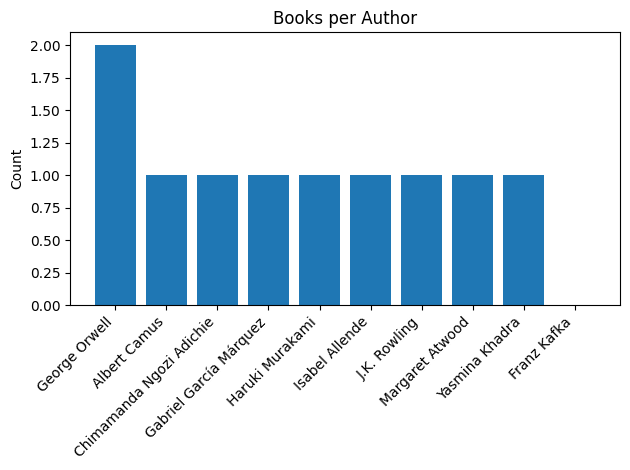

In [57]:

import matplotlib.pyplot as plt

plt.figure()
plt.bar(books_per_author['author_name'], books_per_author['num_books'])
plt.title('Books per Author')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



## Findings 



-  *Data health: Keys remain unique; FKs valid (join has no orphans).*

- New record added: Yasmina Khadra — Ce que le jour doit à la nuit (2008).

- 1→Many confirmed: Each book still maps to exactly one author; authors can have multiple books.

- Book counts by author: George Orwell still has 2 books; all other listed authors (incl. Yasmina Khadra) show 1 book.

- Time coverage updated: Publications now span 1942 → 2008 (range 66 years).

- Earliest: 1942 (The Stranger).

- Latest: 2008 (Ce que le jour doit à la nuit).

- Average year: ≈ 1979.1; median: ≈ 1985.

- Queries & chart: Aggregations and the “Books per Author” bar chart now include Yasmina Khadra with a count of 1.

